In [315]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data.paths.parquet_paths import LOWEST_RATINGS
from matplotlib import cm
import random
import matplotlib.colors as mcolors

In [167]:
df = pd.read_parquet(str(LOWEST_RATINGS))

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5011 entries, 0 to 5010
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   categories        5011 non-null   object 
 1   avg_stars         5011 non-null   float64
 2   category_reviews  5011 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 117.6+ KB


In [169]:
df.describe()

,avg_stars,category_reviews
count,5011.000000,5011.000000
mean,3.887847,69.981241
std,0.944885,212.181061
min,1.000000,3.000000
25%,3.000000,6.000000
50%,4.000000,15.000000
75%,5.000000,54.000000
max,5.000000,4897.000000


In [170]:
avg_stars_q_25 = df['avg_stars'].quantile(0.25)
avg_stars_q_75 = df['avg_stars'].quantile(0.75)
reviews_q_25 = df['category_reviews'].quantile(0.25)
reviews_q_75 = df['category_reviews'].quantile(0.75)

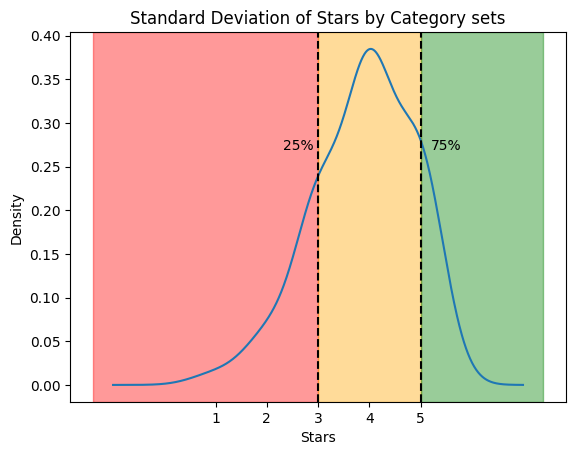

In [171]:
axs = df['avg_stars'].plot.kde(bw_method=0.5, xticks=[1, 2, 3, 4, 5], title='Standard Deviation of Stars by Category sets')
axs.set_xlabel('Stars')
x_left, x_right = axs.get_xlim()
y_bottom, x_top = axs.get_ylim()

axs.axvline(avg_stars_q_25, color='black', linestyle='--')
axs.text(x=avg_stars_q_25/1.3, y=x_top/1.5, s='25%')
axs.axvspan(x_left, avg_stars_q_25, color='red', alpha=0.4)

axs.axvline(avg_stars_q_75, color='black', linestyle='--')
axs.text(x=avg_stars_q_75/0.96, y=x_top/1.5, s='75%')
axs.axvspan(avg_stars_q_25, avg_stars_q_75, color='orange', alpha=0.4)

axs.axvspan(avg_stars_q_75, x_right, color='green', alpha=0.4)

plt.show()

In [172]:
#       avg_stars	category_reviews
# 25%	3.000000	     6.000000
# 50%	4.000000	    15.000000
# 75%	5.000000	    54.000000
df_quantile_lt_25perc = df.loc[
    (df['avg_stars'] < avg_stars_q_25) & 
    (df['category_reviews'] < reviews_q_25)
].copy()

df_quantile_gte_25_lt_75perc = df.loc[
    (avg_stars_q_25 <= df['avg_stars']) & 
    (df['avg_stars'] < avg_stars_q_75) & 
    (reviews_q_25 <= df['category_reviews']) &
    (df['category_reviews'] < reviews_q_75)
].copy()

df_quantile_gte_75perc = df.loc[
    (df['avg_stars'] >= avg_stars_q_75) & 
    (df['category_reviews'] >= reviews_q_75)
].copy()

In [173]:
print(f"{df_quantile_lt_25perc.shape=}\n{df.shape=}")

df_quantile_lt_25perc.shape=(150, 3)
df.shape=(5011, 3)


In [174]:
def get_similar_category_sets(row):
    similarity_precision = 4
    src_categories = row['categories']
    similar_categories = []
    for idx, df_row in df_quantile_lt_25perc.iterrows():
        if row.name == idx:
            continue
        trg_categories = df_row['categories']
        same_arr = [src_category for src_category in src_categories if src_category in trg_categories]
        if len(same_arr) >= similarity_precision:
            similar_categories.append(sorted(same_arr))
            
    return similar_categories
                

In [175]:
worst_category_sets_df = pd.DataFrame(df_quantile_lt_25perc.apply(get_similar_category_sets, axis=1), columns=['categories'])
mid_category_sets_df = pd.DataFrame(df_quantile_gte_25_lt_75perc.apply(get_similar_category_sets, axis=1), columns=['categories'])
best_category_sets_df = pd.DataFrame(df_quantile_gte_75perc.apply(get_similar_category_sets, axis=1), columns=['categories'])

In [176]:
def empty_list_to_nan(x):
    return np.nan if len(x) == 0 else x


In [177]:
worst_category_sets_df['categories'] = worst_category_sets_df['categories'].apply(empty_list_to_nan)
mid_category_sets_df['categories'] = mid_category_sets_df['categories'].apply(empty_list_to_nan)
best_category_sets_df['categories'] = best_category_sets_df['categories'].apply(empty_list_to_nan)
worst_category_sets_df = worst_category_sets_df.dropna()
mid_category_sets_df = mid_category_sets_df.dropna()
best_category_sets_df = best_category_sets_df.dropna()

In [178]:
def count_categories_appearances(df) -> pd.DataFrame:
    df = df.explode('categories', ignore_index=True)
    df['categories'] = df['categories'].astype('str')
    df = df.groupby('categories').value_counts().reset_index(name='appearances')
    return df

Worst category sets

In [179]:
worst_category_set_appearances_df = count_categories_appearances(worst_category_sets_df)
worst_category_set_appearances_df = worst_category_set_appearances_df.sort_values('appearances', ascending=False)

In [254]:
worst_category_set_appearances_df.head(10)

,categories,appearances
13,"['Doctors', 'Family Practice', 'Health & Medic...",6
8,"['Beauty & Spas', 'Doctors', 'Health & Medical...",6
23,"['Local Services', 'Office Equipment', 'Printi...",4
22,"['IT Services & Computer Repair', 'Local Servi...",2
21,"['IT Services & Computer Repair', 'Local Servi...",2
20,"['IT Services & Computer Repair', 'Local Servi...",2
19,"['Home Services', 'Internet Service Providers'...",2
18,"['Home Cleaning', 'Home Services', 'Pressure W...",2
17,"['Electronics', 'IT Services & Computer Repair...",2
16,"['Electronics', 'Electronics Repair', 'Local S...",2


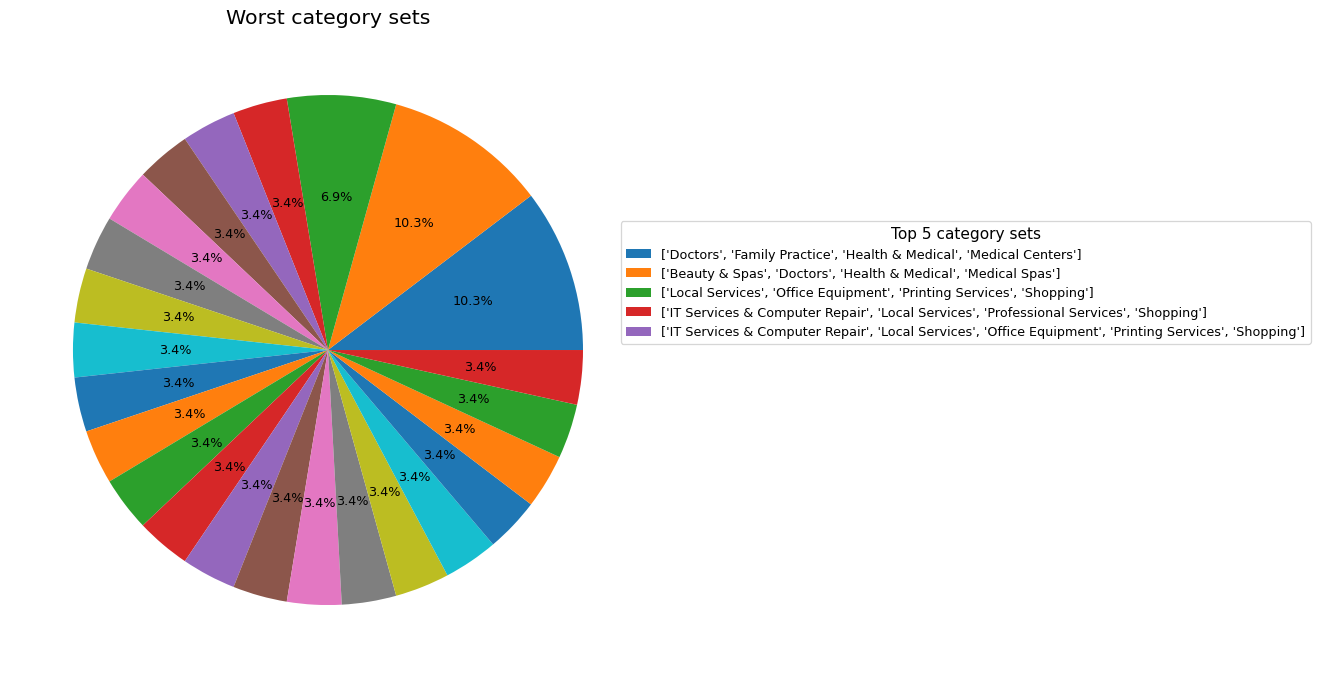

In [336]:
labels = worst_category_set_appearances_df['categories'].to_list()[:5]
x = worst_category_set_appearances_df['appearances']

plt.figure(figsize=(9, 9), dpi=92)
plt.pie(x=x, autopct='%.1f%%')
plt.gca().set_title('Worst category sets', fontsize=16)
plt.legend(title='Top 5 category sets', labels=labels, loc='lower center', bbox_to_anchor=(1.5, 0.5), title_fontsize=12)
plt.show()

So we might say these category sets are worst: \
**["Beauty & Spas", "Doctors", "Health & Medical", "Medical Spas"]** \
**["Doctors", "Family Practice", "Health & Medical", "Medical Centers"]** \
**["Local Services", "Office Equipment", "Printing Services", "Shopping"]**

Mid category sets

In [182]:
mid_category_set_appearances_df = count_categories_appearances(mid_category_sets_df)
mid_category_set_appearances_df = mid_category_set_appearances_df.sort_values('appearances', ascending=False)

In [183]:
mid_category_set_appearances_df.head()

,categories,appearances
87,"['Bars', 'Nightlife', 'Pubs', 'Restaurants']",18
176,"['Contractors', 'Home & Garden', 'Home Service...",15
143,"['Books', 'Mags', 'Music & Video', 'Shopping']",15
226,"['Fashion', ""Men's Clothing"", 'Shopping', ""Wom...",15
74,"['Bars', 'Beer', 'Food', 'Nightlife', 'Restaur...",14


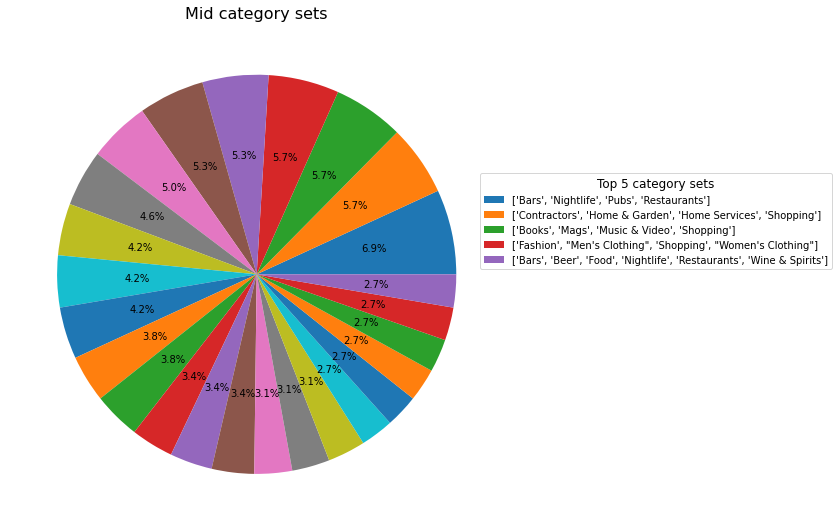

In [338]:
labels = mid_category_set_appearances_df['categories'].to_list()[:5]
x = mid_category_set_appearances_df['appearances'].iloc[:25]

plt.figure(figsize=(9, 9), dpi=72)
plt.pie(x=x, autopct='%.1f%%')
plt.gca().set_title('Mid category sets', fontsize=16)
plt.legend(title='Top 5 category sets', labels=labels, loc='lower center', bbox_to_anchor=(1.3, 0.5), title_fontsize=12)
plt.show()

Mid category sets: \
**["Bars", "Nightlife", "Pubs", "Restaurants"]** \
**["Fashion", "Men\'s Clothing", "Shopping", "Women\'s Clothing"]** \
**["Contractors", "Home & Garden", "Home Services", "Shopping"]** \
**["Books", "Mags", "Music & Video", "Shopping"]** \
**["Bars", "Beer", "Food", "Nightlife", "Restaurants", "Wine & Spirits"]** \
**["Doctors", "Family Practice", "Health & Medical", "Medical Centers"]** 

Best category sets

In [185]:
best_category_set_appearances_df = count_categories_appearances(best_category_sets_df)
best_category_set_appearances_df = best_category_set_appearances_df.sort_values('appearances', ascending=False)

In [186]:
best_category_set_appearances_df.head(10)

,categories,appearances
23,"['Bars', 'Nightlife', 'Pubs', 'Restaurants']",5
6,"['American (Traditional)', 'Bars', 'Nightlife'...",4
41,"['Coffee & Tea', 'Food', 'Juice Bars & Smoothi...",4
22,"['Bars', 'Nightlife', 'Pizza', 'Restaurants']",3
21,"['Bars', 'Food', 'Nightlife', 'Restaurants']",3
11,"['Auto Repair', 'Automotive', 'Oil Change Stat...",3
46,"['Contractors', 'Home & Garden', 'Home Service...",3
56,"['Ethnic Food', 'Food', 'Imported Food', 'Rest...",2
15,"['Bars', 'Beer', 'Food', 'Nightlife', 'Pubs', ...",2
24,"['Bars', 'Nightlife', 'Restaurants', 'Seafood']",2


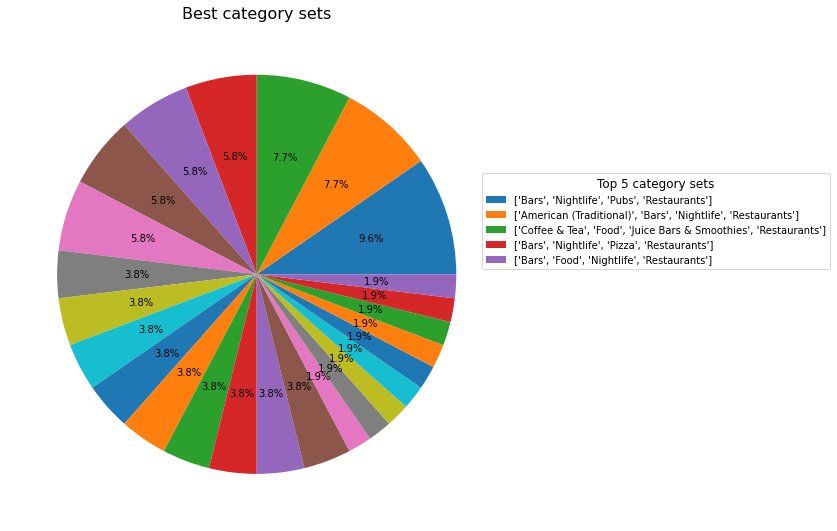

In [340]:
labels = best_category_set_appearances_df['categories'].to_list()[:5]
x = best_category_set_appearances_df['appearances'].iloc[:25]

plt.figure(figsize=(9, 9), dpi=72)
plt.pie(x=x, autopct='%.1f%%')
plt.gca().set_title('Best category sets', fontsize=16)
plt.legend(title='Top 5 category sets', labels=labels, loc='lower center', bbox_to_anchor=(1.3, 0.5), title_fontsize=12)
plt.show()

So here is **the problem** \
There can be ambiguous category sets and I don't know how to deal with them 

Let's dive into such category sets

Explore **Worst** and **Mid** category sets intersection

In [188]:
worst_mid_intersection_df = worst_category_set_appearances_df.join(
    mid_category_set_appearances_df.set_index('categories'), 
    on='categories', 
    how='inner',
    lsuffix='_worst', 
    rsuffix='_mid'
)

worst_mid_intersection_df.head(10)

,categories,appearances_worst,appearances_mid
13,"['Doctors', 'Family Practice', 'Health & Medic...",6,14
8,"['Beauty & Spas', 'Doctors', 'Health & Medical...",6,10
23,"['Local Services', 'Office Equipment', 'Printi...",4,4
22,"['IT Services & Computer Repair', 'Local Servi...",2,1
21,"['IT Services & Computer Repair', 'Local Servi...",2,1
20,"['IT Services & Computer Repair', 'Local Servi...",2,5
18,"['Home Cleaning', 'Home Services', 'Pressure W...",2,1
17,"['Electronics', 'IT Services & Computer Repair...",2,3
16,"['Electronics', 'Electronics Repair', 'Local S...",2,2
15,"['Doctors', 'Health & Medical', 'Medical Cente...",2,1


Let's find categories that are only in worst sets

In [189]:
worst_without_mid_df = pd.merge(
    worst_category_set_appearances_df, 
    mid_category_set_appearances_df.set_index('categories'), 
    how='left', 
    on='categories', 
    suffixes=("_worst", '_mid'),
    indicator=True
)
worst_without_mid_df = worst_without_mid_df[worst_without_mid_df['_merge'] == 'left_only'][['categories', 'appearances_worst']]
worst_without_mid_df

,categories,appearances_worst
6,"['Home Services', 'Internet Service Providers'...",2
11,"['Doctors', 'Health & Medical', 'Internal Medi...",2
13,"['Active Life', 'Child Care & Day Care', 'Educ...",2
15,"['Community Service/Non-Profit', 'Health & Med...",2
22,"['Acupuncture', 'Chiropractors', 'Health & Med...",2


**Worst** and **Best** categories intersection

In [190]:
worst_best_intersection_df = worst_category_set_appearances_df.join(
    best_category_set_appearances_df.set_index('categories'), 
    on='categories', 
    how='inner',
    lsuffix='_worst', 
    rsuffix='_best'
)

worst_best_intersection_df

,categories,appearances_worst,appearances_best
20,"['IT Services & Computer Repair', 'Local Servi...",2,1
16,"['Electronics', 'Electronics Repair', 'Local S...",2,1
11,"['Contractors', 'Home & Garden', 'Home Service...",2,3
7,"['Beauty & Spas', 'Day Spas', 'Hair Removal', ...",2,1


Exclude best from worst categories

In [224]:
worst_without_best_df = pd.merge(
    worst_category_set_appearances_df, 
    best_category_set_appearances_df.set_index('categories'), 
    how='left', 
    on='categories', 
    suffixes=("_worst", '_best'),
    indicator=True
)
worst_without_best_df = worst_without_best_df[worst_without_best_df['_merge'] == 'left_only'][['categories', 'appearances_worst']]
worst_without_best_df.head(5)

,categories,appearances_worst
0,"['Doctors', 'Family Practice', 'Health & Medic...",6
1,"['Beauty & Spas', 'Doctors', 'Health & Medical...",6
2,"['Local Services', 'Office Equipment', 'Printi...",4
3,"['IT Services & Computer Repair', 'Local Servi...",2
4,"['IT Services & Computer Repair', 'Local Servi...",2


Get **Best** and **Mid** categories intersection

In [223]:
mid_best_intersection_df = mid_category_set_appearances_df.join(
    best_category_set_appearances_df.set_index('categories'), 
    on='categories', 
    how='inner',
    lsuffix='_mid', 
    rsuffix='_best'
)

mid_best_intersection_df.head(5)

,categories,appearances_mid,appearances_best
87,"['Bars', 'Nightlife', 'Pubs', 'Restaurants']",18,5
176,"['Contractors', 'Home & Garden', 'Home Service...",15,3
74,"['Bars', 'Beer', 'Food', 'Nightlife', 'Restaur...",14,1
40,"['American (Traditional)', 'Bars', 'Nightlife'...",12,4
89,"['Bars', 'Nightlife', 'Restaurants', 'Sports B...",11,1


Let's get ONLY WORST categories

In [239]:
trully_worst_category_set_df = worst_category_set_appearances_df.loc[
    (~worst_category_set_appearances_df.isin(worst_mid_intersection_df['categories'])['categories']) & 
    (~worst_category_set_appearances_df.isin(worst_best_intersection_df['categories'])['categories'])
].copy()

Trully worst category sets

In [240]:
trully_worst_category_set_df['categories'].to_list()

["['Home Services', 'Internet Service Providers', 'Local Services', 'Professional Services', 'Television Service Providers']",
 "['Doctors', 'Health & Medical', 'Internal Medicine', 'Pulmonologist']",
 "['Active Life', 'Child Care & Day Care', 'Education', 'Local Services', 'Preschools']",
 "['Community Service/Non-Profit', 'Health & Medical', 'Local Services', 'Medical Centers']",
 "['Acupuncture', 'Chiropractors', 'Health & Medical', 'Physical Therapy']"]

And in the end we must verify such categories 

In [277]:
import ast

worst_category_sets_list = list(map(ast.literal_eval, trully_worst_category_set_df['categories'].to_list()))

In [278]:
have_not_only_worst = {}

for worst_category_set in worst_category_sets_list:
    print(f"{worst_category_set=}")
    gt_q_25_count = df.loc[
        df['categories'].apply(lambda categories: all(cat in categories for cat in worst_category_set))
    ].query('avg_stars > @avg_stars_q_25').shape[0]
    print(f"Not worst category count {gt_q_25_count}")
    if gt_q_25_count > 0:
        have_not_only_worst.update({str(worst_category_set): gt_q_25_count})

worst_category_set=['Home Services', 'Internet Service Providers', 'Local Services', 'Professional Services', 'Television Service Providers']
Not worst category count 0
worst_category_set=['Doctors', 'Health & Medical', 'Internal Medicine', 'Pulmonologist']
Not worst category count 1
worst_category_set=['Active Life', 'Child Care & Day Care', 'Education', 'Local Services', 'Preschools']
Not worst category count 3
worst_category_set=['Community Service/Non-Profit', 'Health & Medical', 'Local Services', 'Medical Centers']
Not worst category count 0
worst_category_set=['Acupuncture', 'Chiropractors', 'Health & Medical', 'Physical Therapy']
Not worst category count 0


In [341]:
# worst_category_set = ('Home Services', 'Internet Service Providers', 'Local Services', 'Professional Services', 'Television Service Providers')
# worst_category_set = ('Doctors', 'Health & Medical', 'Internal Medicine', 'Pulmonologist')
worst_category_set = ('Active Life', 'Child Care & Day Care', 'Education', 'Local Services', 'Preschools')
# worst_category_set = ('Community Service/Non-Profit', 'Health & Medical', 'Local Services', 'Medical Centers')
# worst_category_set = ('Acupuncture', 'Chiropractors', 'Health & Medical', 'Physical Therapy')

df.loc[
    df['categories'].apply(lambda categories: all(cat in categories for cat in worst_category_set))
].query('avg_stars > @avg_stars_q_25')

,categories,avg_stars,category_reviews
1650,"[Active Life, Arts & Entertainment, Business C...",4.0,22
2327,"[Active Life, Child Care & Day Care, Education...",4.0,61
3746,"[Active Life, Child Care & Day Care, Education...",5.0,6


Okay, so we have 2 category sets that are widely distributed on worst, mid and best categories 

*('Active Life', 'Child Care & Day Care', 'Education', 'Local Services', 'Preschools')* \
*('Doctors', 'Health & Medical', 'Internal Medicine', 'Pulmonologist')*


And the rest of **TULLY WORST** category sets:

**('Home Services', 'Internet Service Providers', 'Local Services', 'Professional Services', 'Television Service Providers')** \
**('Community Service/Non-Profit', 'Health & Medical', 'Local Services', 'Medical Centers')** \
**('Acupuncture', 'Chiropractors', 'Health & Medical', 'Physical Therapy')**

And at the end let's find out what are the best category sets

In [284]:
trully_best_category_set_df = best_category_set_appearances_df.loc[
    (~best_category_set_appearances_df.isin(mid_best_intersection_df['categories'])['categories']) & 
    (~best_category_set_appearances_df.isin(worst_best_intersection_df['categories'])['categories'])
].copy()

In [342]:
trully_best_category_set_df['categories'].to_list()

["['Bars', 'Nightlife', 'Pubs', 'Restaurants']",
 "['American (Traditional)', 'Bars', 'Nightlife', 'Restaurants']",
 "['Coffee & Tea', 'Food', 'Juice Bars & Smoothies', 'Restaurants']",
 "['Bars', 'Nightlife', 'Pizza', 'Restaurants']",
 "['Bars', 'Food', 'Nightlife', 'Restaurants']",
 "['Auto Repair', 'Automotive', 'Oil Change Stations', 'Tires']",
 "['Contractors', 'Home & Garden', 'Home Services', 'Shopping']",
 "['Ethnic Food', 'Food', 'Imported Food', 'Restaurants', 'Specialty Food']",
 "['Bars', 'Beer', 'Food', 'Nightlife', 'Pubs', 'Restaurants', 'Wine & Spirits']",
 "['Bars', 'Nightlife', 'Restaurants', 'Seafood']",
 "['Auto Repair', 'Automotive', 'Body Shops', 'Tires']",
 "['Ethnic Food', 'Food', 'Restaurants', 'Specialty Food']",
 "['Home & Garden', 'Home Services', 'Kitchen & Bath', 'Shopping']",
 "['Beauty & Spas', 'Hair Salons', 'Hair Stylists', 'Makeup Artists']",
 "['Beer', 'Food', 'Restaurants', 'Wine & Spirits']",
 "['Bars', 'Beer', 'Food', 'Nightlife', 'Wine & Spirits']

In [288]:
import ast

best_category_sets_list = list(map(ast.literal_eval, trully_best_category_set_df['categories'].to_list()))

In [292]:
have_not_only_best = {}

for best_category_set in best_category_sets_list:
    print(f"{best_category_set=}")
    lt_q_75_count = df.loc[
        df['categories'].apply(lambda categories: all(cat in categories for cat in best_category_set))
    ].query('avg_stars < @avg_stars_q_75').shape[0]
    print(f"Not worst category count {lt_q_75_count}")
    if lt_q_75_count > 0:
        have_not_only_best.update({str(best_category_set): lt_q_75_count})

best_category_set=['Bars', 'Nightlife', 'Pubs', 'Restaurants']
Not worst category count 66
best_category_set=['American (Traditional)', 'Bars', 'Nightlife', 'Restaurants']
Not worst category count 92
best_category_set=['Coffee & Tea', 'Food', 'Juice Bars & Smoothies', 'Restaurants']
Not worst category count 9
best_category_set=['Bars', 'Nightlife', 'Pizza', 'Restaurants']
Not worst category count 34
best_category_set=['Bars', 'Food', 'Nightlife', 'Restaurants']
Not worst category count 69
best_category_set=['Auto Repair', 'Automotive', 'Oil Change Stations', 'Tires']
Not worst category count 15
best_category_set=['Contractors', 'Home & Garden', 'Home Services', 'Shopping']
Not worst category count 18
best_category_set=['Ethnic Food', 'Food', 'Imported Food', 'Restaurants', 'Specialty Food']
Not worst category count 10
best_category_set=['Bars', 'Beer', 'Food', 'Nightlife', 'Pubs', 'Restaurants', 'Wine & Spirits']
Not worst category count 12
best_category_set=['Bars', 'Nightlife', 'Rest

In [296]:
have_not_only_best = dict(sorted(have_not_only_best.items(), key=lambda x: x[1], reverse=False))

There is too much information. Let's slice it lil bit

In [297]:
{key: val for key, val in have_not_only_best.items() if val < 4}

{"['Auto Repair', 'Automotive', 'Body Shops', 'Tires']": 1,
 "['Contractors', 'Home Services', 'Landscaping', 'Masonry/Concrete']": 1,
 "['Contractors', 'Heating & Air Conditioning/HVAC', 'Home & Garden', 'Home Services', 'Plumbing', 'Shopping', 'Water Heater Installation/Repair']": 1,
 "['Contractors', 'Electricians', 'Home Services', 'Solar Installation']": 1,
 "['Home Automation', 'Home Services', 'Local Services', 'Professional Services']": 1,
 "['Home Automation', 'Home Services', 'Local Services', 'Security Systems', 'TV Mounting']": 1,
 "['Carpet Cleaning', 'Home Cleaning', 'Home Services', 'Local Services', 'Office Cleaning', 'Pressure Washers', 'Professional Services']": 1,
 "['Auto Detailing', 'Automotive', 'Local Services', 'Professional Services']": 1,
 "['Active Life', 'Hotels & Travel', 'Local Services', 'Recreation Centers']": 2,
 "['Electronics', 'Electronics Repair', 'IT Services & Computer Repair', 'Local Services', 'Mobile Phone Repair', 'Shopping']": 2,
 "['Carpetin

So up here we have almost perfect category sets